# Gecko dataset modelling

    
### Dataset columns descriptions

##### Original variables that were scaled:
- **id** - A unique molecule index used in naming files

- **pSat_Pa** - The saturation vapour pressure of the molecule calculated by COSMOtherm (Pa)
- **MW** - The molecular weight of the molecule (g/mol).
- **NumOfAtoms** - The number of atoms in the molecule
- **NumOfC** - The number of carbon atoms in the molecule
- **NumOfO** - The number of oxygen atoms in the molecul
- **NumOfN** - The number of nitrogen atoms in the molecule
- **NumHBondDonors** - “The number of hydrogen bond donors in the molecule, i.e. hydrogens bound to oxygen.”
- **NumOfConf** - The number of stable conformers found and successfully calculated by COSMOconf.
- **NumOfConfUsed** - The number of conformers used to calculate the thermodynamic properties.

- **cc** - The number of non-aromatic C=C bounds found in the molecule.
- **ccco** - The number of “C=C-C=O” structures found in non-aromatic rings in the molecule.
- **hydroxyl_alkl** - The number of the alkylic hydroxyl groups found in the molecule.
- **aldehyde** - The number of aldehyde groups in the molecule.
- **ketone** - The number of ketone groups in the molecule.

- **carboxylic_acid** - The number of carboxylic acid groups in the molecule.
- **ester** - The number of ester groups in the molecule.
- **ether_alicyclic** - The number of alicyclic ester groups in the molecule.
- **nitrate** - The number of alicyclic nitrate groups in the molecule
- **nitro** - The number of nitro ester groups in the molecule
- **aromatic_hydroxyl** - The number of alicyclic aromatic hydroxyl groups in the molecule.
- **carbonylperoxynitrate** - The number of carbonylperoxynitrate groups in the molecule.
- **peroxide** - The number of peroxide groups in the molecule
- **hydroperoxide** - The number of hydroperoxide groups in the molecule.
- **carbonylperoxyacid** - The number of carbonylperoxyacid groups found in the molecule
- **nitroester** - The number of nitroester groups found in the molecule
- **parentspecies** - Either “decane”, “toluene”, “apin” for alpha-pinene or a combination of these connected by an underscore to indicate ambiguous descent. In 243 cases, the parent species is “None” because it was not possible to retrieve it.
    

##### Transformed or created variables (also scaled):
                
- **trans_NumOfConf** - NumOfConf to the power of 0.3           
- **trans_MW** - Square root of trans_MW              
- **trans_pSat_Pa** - log transformed pSat_Pa                  
- **new_MW_hydroxyl_alkl_interaction** - interaction term between MW and hydroxyl_alkl
- **new_polarity_score** - polarity with assigning different weights to functional group features               
- **new_num_pca_1** - First principal component for all variable with "Num" in names               
- **new_num_pca_2** - Second principal component for all variable with "Num" in names                  

#### Variables for the one hot encoding for parentspecies:
- **ohe_parentspecies_apin** - parentspecies category apin
- **ohe_parentspecies_apin_decane** - parentspecies category decane
- **ohe_parentspecies_apin_decane_toluene** - parentspecies category apin_decane_toluene
- **ohe_parentspecies_apin_toluene** - parentspecies category apin_toluene
- **ohe_parentspecies_decane** - parentspecies category decane
- **ohe_parentspecies_decane_toluene** - parentspecies category decane_toluene

In [1]:
# Import required packages
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.decomposition import PCA, KernelPCA

data_dir = Path("data")
train_data_path = data_dir / "gecko_ml.csv"
test_data_path = data_dir / "gecko_ml_test.csv"

In [7]:
def prepare_data(path: Path, features: list, target: list=None):
    """Load data from the given path, select required features, preprocess the data
    and if needed select the target
    """
    dataset = pd.read_csv(path)
    if not target:
        # Test dataset lacks this column, but it is present in the training set
        dataset["ohe_parentspecies_decane_toluene"] = 0.0

    x = dataset[features]
    
    # One hot encoding of parentspecies column has Nan values, 
    # I decided to keep the rows with Nans and set each of the ohe* variables to one 
    x[x[["ohe_parentspecies_apin",
    "ohe_parentspecies_apin_decane",
    "ohe_parentspecies_apin_decane_toluene",
    "ohe_parentspecies_apin_toluene",
    "ohe_parentspecies_decane",
    "ohe_parentspecies_decane_toluene"]].isna()] = 1.0

    # id column is not a meanigful feature
    x = x.drop("id", axis=1)
    if target:
        y = dataset[target]
        return x, y
    else:
        return x
    
def transform_predictions(predictions):
    """Reverse transformation applied to the target variable. First unscales the variable based on the mean and std values from the training set
    then applies exp function. Verified to work properly on the train set."""
    df = pd.read_csv("data/train.csv")
    orig_log_mean = np.log(df["pSat_Pa"]).mean()
    orig_log_std = np.log(df["pSat_Pa"]).std()
    unscaled = unscale(predictions, orig_log_mean, orig_log_std)
    return np.exp(unscaled)

def unscale_orig_target(target):
    """Unscale the value of pSat_Pa to obtain the original values. Verified to work properly for the train set."""
    df = pd.read_csv("data/train.csv")
    orig_mean = df["pSat_Pa"].mean()
    orig_std = df["pSat_Pa"].std()
    return unscale(target, orig_mean, orig_std)

def unscale(variable, mean, std):
    return std * variable + mean

def scale(variable, mean, std):
    return (variable - mean) / std

def save_test_predictions(test_predictions, save_path, original_test_file):
    original_test = pd.read_csv(original_test_file)
    original_test["target"] = test_predictions
    original_test["Id"] = original_test["id"]
    result = original_test[["Id", "target"]]
    result.to_csv(save_path, index=False)

def cross_validate_model(model, x, y, cv=10, scoring='r2'):
    scores = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return scores.mean()


def find_best_feature_subset(coeff, model, x, y, start=0):
    abs_coeff = np.abs(coeff)
    search_space = np.sort(abs_coeff)[start:-1][::-1]
    search_space = search_space[search_space != 0] # don't use features with zero coefficents
    scores = []
    feats = []
    for i, val in enumerate(search_space):
        selected_feats = x.columns[abs_coeff >= val]
        if selected_feats.size == 0:
            continue
        scores.append(cross_validate_model(model, x[selected_feats], y, cv=5))
        feats.append(selected_feats.values)
        # print(f"Num features: {selected_feats.size}, current score: {scores[-1]}")
    max_score = np.max(scores)
    best_feats = feats[np.argmax(scores)]
    return best_feats, max_score, feats, scores

def validate_models(models: dict, x, y, test_name="baseline"):
    result = []
    for name, model in models.items():
        print(f"Validating model {name}")
        result.append(cross_validate_model(model, x, y))
        
    return pd.DataFrame({test_name:result}, index=models.keys())

def load_x_y(features, target="log10"):
    dependant = ['pSat_Pa', 'trans_pSat_Pa']
    x, y = prepare_data(train_data_path, features, target=dependant)
    x, y = shuffle(x, y)
    y_org = y[dependant[0]]
    y_trans = y[dependant[1]]
    y_log10 = np.log10(unscale_orig_target(y_org))
    y_log10_scaled = scale(y_log10, y_log10.mean(), y_log10.std())
    if target == "original":
        return x, y_org
    elif target == "transformed":
        return x, y_trans
    elif target == "log10":
        return x, y_log10
    elif target == "log10_scaled":
        return x, y_log10_scaled
    else:
        raise KeyError
    
def _feature_selection(coef, model, x, y, k):
    best = find_best_feature_subset(coef, model, x, y)
    best_feats, best_feats_score, feats, feats_scores = best
    if k == 1:
        return best_feats, np.std(feats_scores)
    else:
        sortedsargs = np.argsort(feats_scores)[-k:]
        return feats[sortedsargs[::-1]], feats_scores[sortedsargs[::-1]]

def linear_model_feature_selection(models, x, y, k=1):
    models["elasticnet"].fit(x, y)
    return _feature_selection(models["elasticnet"].coef_, models["lin_reg"], x, y, k)

def selectkbest_feature_selection(models, x, y, k=1):
    fs = SelectKBest(f_regression, k='all')
    fs.fit(x, y)
    return _feature_selection(fs.scores_, models["lin_reg"], x, y, k)

def save_feats(feats, filename):
    df = pd.DataFrame([], index=feats)
    df.to_csv(f"features/{filename}")

def find_best_model(models):
    features = ['id', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
        'NumHBondDonors', 'NumOfConfUsed', 'cc', 'ccco',
        'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
        'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
        'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
        'carbonylperoxyacid', 'nitroester', 'trans_NumOfConf',
        'trans_MW',
        'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
        'ohe_parentspecies_apin_decane_toluene',
        'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
        'ohe_parentspecies_decane_toluene']
    features_full = ['id', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
        'NumHBondDonors', 'NumOfConfUsed', 'cc', 'ccco',
        'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
        'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
        'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
        'carbonylperoxyacid', 'nitroester', 'trans_NumOfConf',
        'trans_MW', 'new_MW_hydroxyl_alkl_interaction',
        'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
        'ohe_parentspecies_apin_decane_toluene', 'new_polarity_score', 'new_num_pca_1', 'new_num_pca_2',
        'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
        'ohe_parentspecies_decane_toluene']
    x, y = load_x_y(features_full)

    lin_feats, lin_std = linear_model_feature_selection(models, x, y)
    skb_feats, skb_std = selectkbest_feature_selection(models, x, y)
    print(f"Lin feats:\n {lin_feats}")
    print(f"SKB feats:\n {skb_feats}")
    print(lin_std, skb_std)
    lin_x = x[lin_feats]
    skb_x = x[skb_feats]
    lin_scores = validate_models(models, lin_x, y)
    skb_scores = validate_models(models, skb_x, y)
    print(lin_scores)
    print(skb_scores)
    # save_feats(lin_feats, f"lin_svrscore_{lin_scores['svr']:0.4f}.csv" )
    # save_feats(skb_feats, f"skb_svrscore_{skb_scores['svr']:0.4f}.csv" )
    return lin_feats, skb_feats

def generate_test_preds(model, feature_dir='features', pred_dir='predictions'):
    features_full = ['id', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
        'NumHBondDonors', 'NumOfConfUsed', 'cc', 'ccco',
        'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
        'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
        'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
        'carbonylperoxyacid', 'nitroester', 'trans_NumOfConf',
        'trans_MW', 'new_MW_hydroxyl_alkl_interaction',
        'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
        'ohe_parentspecies_apin_decane_toluene', 'new_polarity_score', 'new_num_pca_1', 'new_num_pca_2',
        'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
        'ohe_parentspecies_decane_toluene']
    x, y = load_x_y(features_full)
    x_test = prepare_data(test_data_path, features_full)
    
    ft_dir = Path(feature_dir)
    for file in ft_dir.glob("*"):
        feats = pd.read_csv(file).iloc[:, 0]
        model.fit(x[feats], y)
        preds = model.predict(x_test[feats])
        save_test_predictions(preds, f"{pred_dir}/{file.name}", test_data_path)

In [4]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")




In [5]:
train.describe()

,Id,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,C.C..non.aromatic.,...,ether..alicyclic.,nitrate,nitro,aromatic.hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester,pSat_Pa
count,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,...,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,2.714700e+04
mean,74073.347957,264.436315,26.232843,6.860611,9.928390,1.060964,2.201643,229.643386,25.721921,0.092865,...,0.205142,0.665525,0.154050,0.001105,0.241389,0.279663,0.772977,0.259181,0.012451,5.708431e+01
std,47917.611394,49.858355,5.240883,1.451855,2.494574,0.712067,1.018979,202.905589,14.687277,0.290629,...,0.403813,0.673048,0.366171,0.047001,0.451312,0.448842,0.698533,0.467085,0.112537,5.928184e+03
min,0.000000,30.010565,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.624240e-14
25%,31724.500000,232.980781,23.000000,6.000000,8.000000,1.000000,2.000000,72.000000,11.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.659079e-06
50%,69861.000000,266.986260,26.000000,7.000000,10.000000,1.000000,2.000000,174.000000,30.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.552678e-04
75%,113432.000000,299.012475,30.000000,7.000000,12.000000,2.000000,3.000000,331.000000,40.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.974230e-03
max,166420.000000,386.044503,41.000000,10.000000,17.000000,2.000000,6.000000,1743.000000,40.000000,2.000000,...,1.000000,2.000000,2.000000,3.000000,2.000000,1.000000,4.000000,3.000000,2.000000,7.324992e+05


In [6]:
test.describe()

,Id,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,C.C..non.aromatic.,...,ester,ether..alicyclic.,nitrate,nitro,aromatic.hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester
count,4.490000e+03,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,...,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000,4490.000000
mean,1.002246e+06,261.439483,26.035189,6.782851,9.903563,0.940089,2.469933,245.859020,23.740089,0.069265,...,0.132071,0.187751,0.592873,0.141425,0.000891,0.205791,0.363029,0.832739,0.247216,0.007572
std,1.296296e+03,47.104949,4.811863,1.342726,2.436507,0.702743,1.198354,225.422977,14.536959,0.253933,...,0.402344,0.390556,0.642965,0.351046,0.036549,0.433054,0.480927,0.730183,0.458476,0.086699
min,1.000001e+06,102.068080,10.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.001123e+06,231.329387,23.000000,6.000000,8.000000,0.000000,2.000000,78.000000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.002246e+06,264.084517,26.000000,7.000000,10.000000,1.000000,2.000000,180.000000,24.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.003368e+06,296.996825,29.000000,7.000000,12.000000,1.000000,3.000000,346.000000,40.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.004490e+06,386.044503,41.000000,10.000000,17.000000,2.000000,6.000000,1812.000000,40.000000,1.000000,...,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,4.000000,2.000000,1.000000


In [8]:
features = ['id', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
       'NumHBondDonors', 'NumOfConfUsed', 'cc', 'ccco',
       'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
       'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
       'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
       'carbonylperoxyacid', 'nitroester', 'trans_NumOfConf',
       'trans_MW',
       'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
       'ohe_parentspecies_apin_decane_toluene',
       'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
       'ohe_parentspecies_decane_toluene']
target = ['pSat_Pa', 'trans_pSat_Pa']


original_x, original_y = prepare_data(train_data_path, features, target=target)
x, y = prepare_data(train_data_path, features, target=target)
x_test = prepare_data(test_data_path, features)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

y_train_org = y_train[target[0]]
y_train_trans = y_train[target[1]]
y_train_log10 = np.log10(unscale_orig_target(y_train_org))
y_train_log10_scaled = scale(y_train_log10, y_train_log10.mean(), y_train_log10.std())

y_val_org = y_val[target[0]]
y_val_trans = y_val[target[1]]
y_val_log10 = np.log10(unscale_orig_target(y_val_org))
y_val_log10_scaled = scale(y_val_log10, y_val_log10.mean(), y_val_log10.std())

x, y = shuffle(x, y)
y_org = y[target[0]]
y_trans = y[target[1]]
y_log10 = np.log10(unscale_orig_target(y_org))
y_log10_scaled = scale(y_log10, y_log10.mean(), y_log10.std())


/tmp/ipykernel_5892/3333721820.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x[["ohe_parentspecies_apin",
/tmp/ipykernel_5892/3333721820.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x[["ohe_parentspecies_apin",
/tmp/ipykernel_5892/3333721820.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x[["ohe_p

# Baseline models
In this section I will cross validate several models on the whole dataset and observe their performance.
I will use models:
- linear regression (also with regularization)
- random forest
- support vector regressor
- gradient boosting regressor

I selected these models, because they represent a variety of approaches used to solve regression problems, and also they are the most popular ML models.

In [9]:
# Define the models
lin_reg = LinearRegression()
rf = RandomForestRegressor()
svr = SVR()
gbr = GradientBoostingRegressor()

In [10]:
# Use cross validation to find the best Lasso and Ridge regularization parameters 
elasticnetcv = ElasticNetCV(cv=10)
elasticnetcv.fit(x.to_numpy(), y_log10.to_numpy())
print(elasticnetcv.alpha_, elasticnetcv.l1_ratio_)

0.0030016018911636893 0.5


In [11]:
# Define regularized linear regression model, with parameters influenced by the result of the previous cross validation
# I decided to only use Lasso regression, because it produced better results in my own experiments and has the advantage of producing 0 valued coefficients
elasticnet = ElasticNet(alpha=0.003, l1_ratio=1)

In [12]:
models = {}
models["lin_reg"] = lin_reg
models["rf"] = rf
models["svr"] = svr
models["gbr"] = gbr
models["elasticnet"] = elasticnet

In [13]:
baseline_scores = validate_models(models, x, y_log10)
baseline_scores

Validating model lin_reg
Validating model rf
Validating model svr
Validating model gbr
Validating model elasticnet


,baseline
lin_reg,0.709753
rf,0.713357
svr,0.748012
gbr,0.724085
elasticnet,0.708051


# Feature selection
After calculating the baseline scores, I can start feature selection. I will use several techniques to find the best features. These techniques are:
- Selecting features based on the coefficients of the regularized linear regression model.
- Using feature selection methods built into Sklearn
- Using PCA to transform the feature space and based on that selecting the important principal components

### 1. Feature selection based on the linear regression coefficients

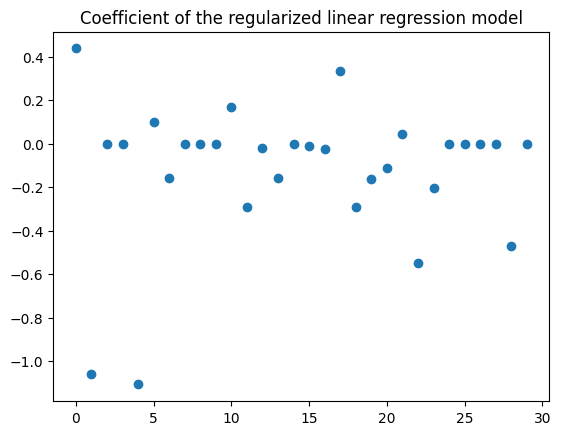

In [33]:
elasticnet.fit(x, y_log10)
plt.scatter(np.arange(elasticnet.coef_.size), elasticnet.coef_)
plt.title("Coefficients of the regularized linear regression model")
plt.show()

Text(0, 0.5, 'Cross validation score')

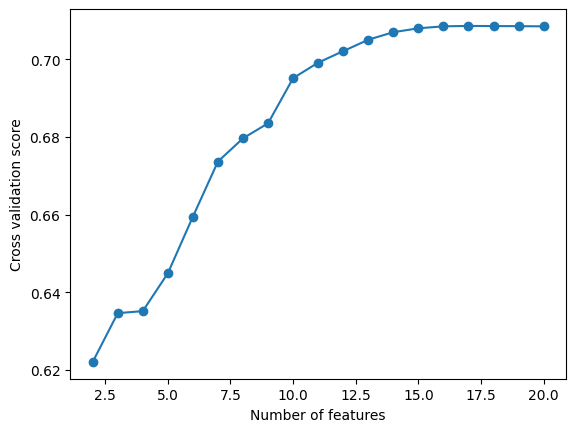

In [34]:
best_feats, best_feats_score, feats, feats_scores = find_best_feature_subset(elasticnet.coef_, lin_reg, x, y_log10)

plt.plot([len(f) for f in feats], feats_scores)
plt.scatter([len(f) for f in feats], feats_scores)

plt.xlabel("Number of features")
plt.ylabel("Cross validation score")

### 2. Using Sklearn built in methods

Text(0, 0.5, 'Cross validation score')

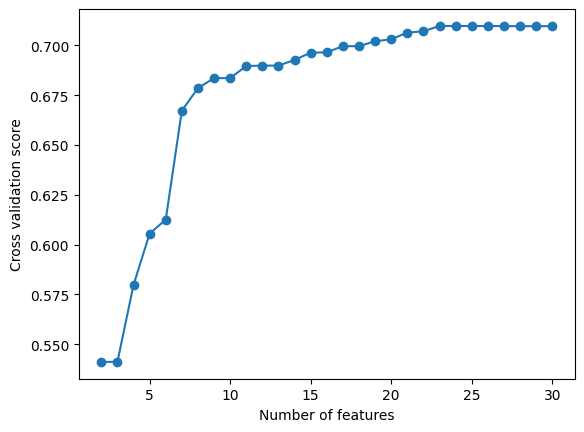

In [35]:
fs = SelectKBest(f_regression, k='all')
fs.fit(x, y_log10)
best_feats_sk, best_feats_score_sk, feats_sk, feats_scores_sk = find_best_feature_subset(fs.scores_, lin_reg, x, y_log10)

plt.plot([len(f) for f in feats_sk], feats_scores_sk)
plt.scatter([len(f) for f in feats_sk], feats_scores_sk)

plt.xlabel("Number of features")
plt.ylabel("Cross validation score")

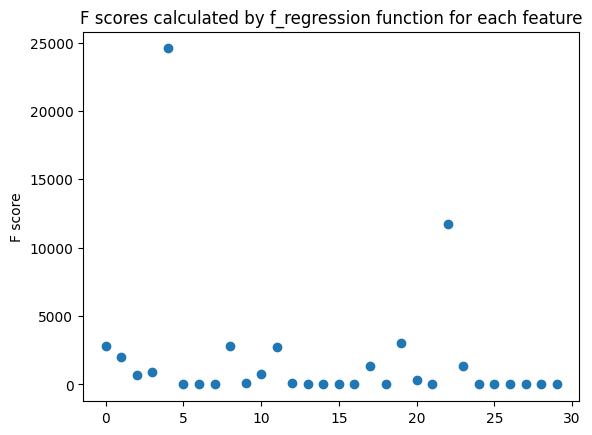

In [31]:
plt.scatter(np.arange(fs.scores_.size), fs.scores_)
plt.title("F scores calculated by f_regression function for each feature")
plt.ylabel("F score")
plt.show()

### 3. PCA

In [42]:
pca = PCA(n_components='mle')
pca.fit(x)
print(f"The best number of principal components is: {pca.components_.shape[0]}")

The best number of principal components is: 28


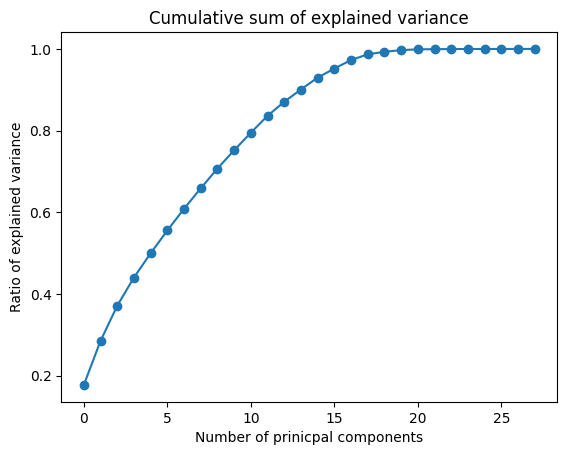

In [43]:
pca = PCA(n_components=28)
pca.fit(x)
pca_ex_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(28), pca_ex_var)
plt.scatter(np.arange(28), pca_ex_var)
plt.title("Cumulative sum of explained variance")
plt.ylabel("Ratio of explained variance")
plt.xlabel("Number of prinicpal components")
plt.show()

### Model comparison based on the selected features

In [ ]:

lin_feats_scores = validate_models(models, x[best_feats], y_log10, "lin reg features")
skb_feats_scores = validate_models(models, x[best_feats_sk], y_log10, "skb features")
pca_scores = validate_models(models, PCA(n_components=28).fit_transform(x), y_log10, "pca")
scores_combined = pd.concat([baseline_scores, lin_feats_scores, skb_feats_scores, pca_scores])
scores_combined

### Additional features

In [18]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
# feats = pd.read_csv("features/lin_svrscore_0.7406.csv").iloc[:, 0]
new_x = poly.fit_transform(x)
cross_validate_model(lin_reg, new_x,  y_log10, cv=5)

0.7226167043393945

In [21]:
test_new = poly.transform(x_test[feats])
svr.fit(new_x, y_log10)
preds = svr.predict(test_new)
save_test_predictions(preds, "predictions/svr_interaction.csv", test_data_path)

### Best parameter selection

In [7]:
from sklearn.model_selection import GridSearchCV
gssvr = GridSearchCV(
    SVR(kernel="rbf", gamma=0.1),
    param_grid={"C": [1e0, 1e3], "gamma": np.logspace(-2, 2, 1)},
    n_jobs=-1
    cv=5
)

gssvr.fit(x, y_log10)
print(f"Best SVR with params: {gssvr.best_params_} and R2 score: {gssvr.best_score_:.3f}")

In [4]:
svr = SVR(C=2.0)
cross_validate_model(svr, x, y_log10)

0.7509643531131507

In [5]:
svr.fit(x, y_log10)
preds = svr.predict(x_test)
save_test_predictions(preds, "predictions/svr_c2.csv", test_data_path)